# Face-Mask Detection using Faster R-CNN (PyTorch) ༼ つ ◕_◕ ༽つ

In [2]:
import os
import cv2
import time
import pandas as pd
import numpy as np

from PIL import Image

import torch
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

import seaborn as sns
import matplotlib.pyplot as plt

DIR_INPUT = "/kaggle/input/face-mask-detection-dataset/"
DIR_IMAGES = DIR_INPUT + "Medical mask/Medical mask/Medical Mask/images/"

In [3]:
### Loading Dataset

df = pd.read_csv(DIR_INPUT + "train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


# Exploring Dataset 📊

In [4]:
### Null Values, Unique Values

unq_values = df["name"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unq_values))

null_values = df.isnull().sum(axis = 0)
print("\n> Null Values in each column <")
print(null_values)

Total Records:  15412
Unique Images:  4326

> Null Values in each column <
name         0
x1           0
x2           0
y1           0
y2           0
classname    0
dtype: int64


In [5]:
### Total Classes

classes = df["classname"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)

Total Classes:  20

> Classes <
 ['face_with_mask' 'mask_colorful' 'face_no_mask'
 'face_with_mask_incorrect' 'mask_surgical' 'face_other_covering'
 'scarf_bandana' 'eyeglasses' 'helmet' 'face_shield' 'sunglasses' 'hood'
 'hat' 'goggles' 'hair_net' 'hijab_niqab' 'other' 'gas_mask'
 'balaclava_ski_mask' 'turban']


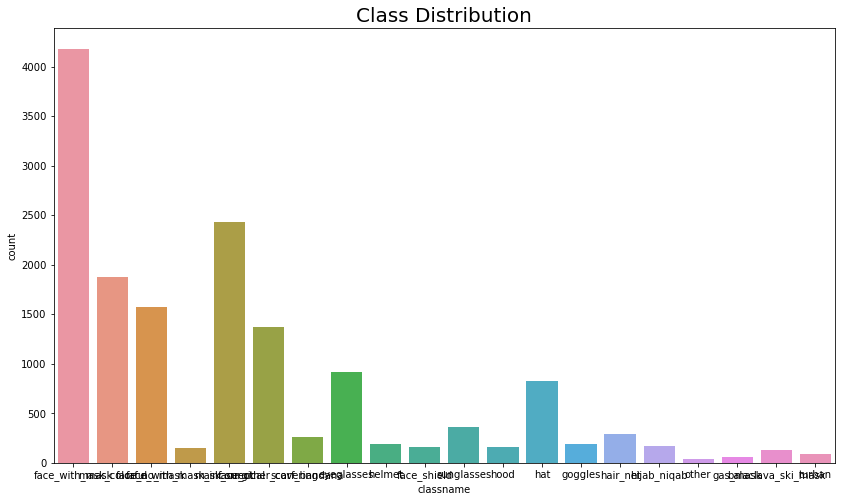

In [6]:
### Visualizing Class Distribution

plt.figure(figsize=(14,8))
plt.title('Class Distribution', fontsize= 20)
sns.countplot(x = "classname", data = df)

# Visualise Random Images with BBox 🕵️‍

In [7]:
### Function to plot image

def plot_img(image_name):
    
    fig, ax = plt.subplots(1, 2, figsize = (14, 14))
    ax = ax.flatten()
    
    bbox = df[df['name'] == image_name]
    img_path = os.path.join(DIR_IMAGES, image_name)
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    for idx, row in bbox.iterrows():
        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        label = row['classname']
        
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, (255,0,0), 2)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

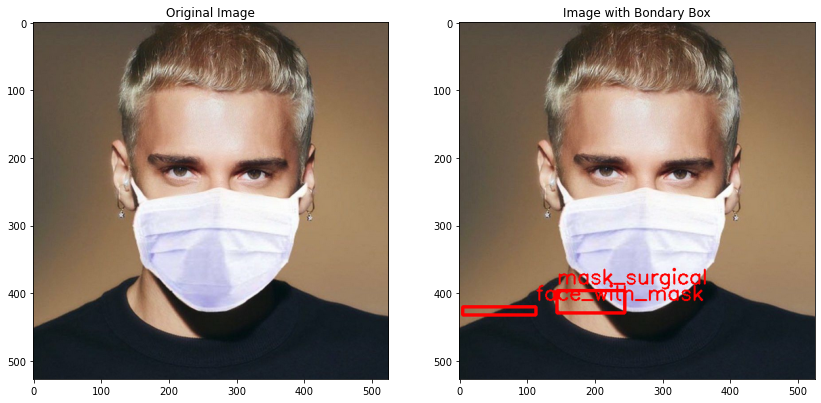

In [8]:
### Pass any image name as parameter

plot_img("3845.png")

**As we can see, column headers (bbox co-ordinates) in 'train.csv' are messed up, need to fix this.**

In [9]:
### Cleaning Column Headers - x2 <-> y1 (mismatched)
df.rename(columns = {'x2' : 'y1', 'y1' : 'x2'}, inplace = True)
df.head()

,name,x1,y1,x2,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


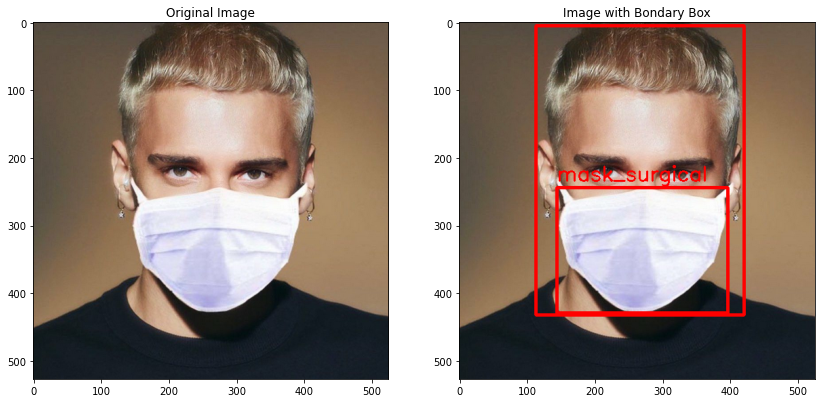

In [10]:
### Re-plot same image

plot_img("3845.png")

**Looks good!**

# Preparing Dataset for Training 📂

In [11]:
### Class <-> Int

_classes = np.insert(classes, 0, "background", axis=0)        # adding a background class for Faster R-CNN
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}
print("class_to_int : \n",class_to_int)
print("\nint_to_class : \n",int_to_class)

class_to_int : 
 {'background': 0, 'face_with_mask': 1, 'mask_colorful': 2, 'face_no_mask': 3, 'face_with_mask_incorrect': 4, 'mask_surgical': 5, 'face_other_covering': 6, 'scarf_bandana': 7, 'eyeglasses': 8, 'helmet': 9, 'face_shield': 10, 'sunglasses': 11, 'hood': 12, 'hat': 13, 'goggles': 14, 'hair_net': 15, 'hijab_niqab': 16, 'other': 17, 'gas_mask': 18, 'balaclava_ski_mask': 19, 'turban': 20}

int_to_class : 
 {0: 'background', 1: 'face_with_mask', 2: 'mask_colorful', 3: 'face_no_mask', 4: 'face_with_mask_incorrect', 5: 'mask_surgical', 6: 'face_other_covering', 7: 'scarf_bandana', 8: 'eyeglasses', 9: 'helmet', 10: 'face_shield', 11: 'sunglasses', 12: 'hood', 13: 'hat', 14: 'goggles', 15: 'hair_net', 16: 'hijab_niqab', 17: 'other', 18: 'gas_mask', 19: 'balaclava_ski_mask', 20: 'turban'}


In [12]:
### Creating Data (Labels & Targets) for Faster R-CNN

class FaceMaskDetectionDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, mode = 'train', transforms = None):
        
        super().__init__()
        
        self.image_names = dataframe["name"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        
    def __getitem__(self, index: int):
        
        #Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df["name"] == image_name]
        
        #Loading Image
        image = cv2.imread(self.image_dir + image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.mode == 'train':
            
            #Get bounding box co-ordinates for each box
            boxes = records[['x1', 'y1', 'x2', 'y2']].values

            #Getting labels for each box
            temp_labels = records[['classname']].values
            labels = []
            for label in temp_labels:
                label = class_to_int[label[0]]
                labels.append(label)

            #Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            #Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels

            #Transforms
            if self.transforms:
                image = self.transforms(image)


            return image, target, image_name
        
        elif self.mode == 'test':

            if self.transforms:
                image = self.transforms(image)

            return image, image_name
    
    def __len__(self):
        return len(self.image_names)
    
    

In [13]:
### Transform for Train & Valid

## Using Albumentations
#def get_transform():
    #return A.Compose([
        #ToTensorV2(p=1.0)
    #], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Using torchvision.transforms - without Augmentation!
def get_transform():
    return T.Compose([T.ToTensor()])

In [14]:
### Preparing data for Train & Validation

def collate_fn(batch):
    return tuple(zip(*batch))


#Dataset object
dataset = FaceMaskDetectionDataset(df, DIR_IMAGES, transforms = get_transform())


# split the dataset in train and test set - using 80% for training, 20% for validation
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-866])
valid_dataset = torch.utils.data.Subset(dataset, indices[-866:])


#Preparing data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle = True,
    num_workers = 4,
    collate_fn = collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 4,
    shuffle = True,
    num_workers = 4,
    collate_fn = collate_fn
)


# Create Model - Resnet50 (Faster R-CNN) 🔨

In [15]:
### Utilize GPU if available

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [16]:
### Create / load model

#Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone = False)
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Preparing Model for Training - Define learning parameters 📝

In [17]:
### Preparing model for training

#Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]

#Defininig Optimizer
#optimizer = torch.optim.Adam(params, lr = 0.0001)
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9)

#LR
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Load pre-trained model
checkpoint = torch.load("../input/face-mask-detection-trained-weights/fmd_frcnn_e23.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.to(device)

#No of epochs
epochs = 1

# Training 

In [18]:
### Training model xD

# Training code is commented for submission, as it takes 11 mins for 1 epoch '-'

"""
itr = 1
total_train_loss = []

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss = []
    
    #Retriving Mini-batch
    for images, targets, image_names in train_data_loader:
        
        #Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        #Forward propagation
        out = model(images, targets)
        losses = sum(loss for loss in out.values())
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        #Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)
        
        if itr % 25 == 0:
            print(f"\n Iteration #{itr} loss: {out} \n")

        itr += 1
    
    #lr_scheduler.step()    
    
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss:.4f}')

    
    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed)
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss
            }, "checkpoint.pth")
"""

'\nitr = 1\ntotal_train_loss = []\n\nfor epoch in range(epochs):\n    \n    start_time = time.time()\n    train_loss = []\n    \n    #Retriving Mini-batch\n    for images, targets, image_names in train_data_loader:\n        \n        #Loading images & targets on device\n        images = list(image.to(device) for image in images)\n        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]\n        \n        #Forward propagation\n        out = model(images, targets)\n        losses = sum(loss for loss in out.values())\n        \n        #Reseting Gradients\n        optimizer.zero_grad()\n        \n        #Back propagation\n        losses.backward()\n        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)\n        optimizer.step()\n        \n        #Average loss\n        loss_value = losses.item()\n        train_loss.append(loss_value)\n        \n        if itr % 25 == 0:\n            print(f"\n Iteration #{itr} loss: {out} \n")\n\n        itr += 1\n    \n    #lr

**Training Details**

* Architecture = ResNet50
* Method = Faster R-CNN
* Pretrained Weights = MS_COCO
* Learning Rate = 0.05
* Optimizer = SGD with momentum 0.9
* Epochs = 25
* Avg Time per Epoch (80% Train Data) = 690 sec



**Loss Details (After 25 Epochs of Training)**

* cls_loss     =  0.0466
* reg_loss     =  0.0125
* obj_loss     =  0.0040
* rpn_reg_loss =  0.0120
* Overall      =  0.0546

# Evaluate Model on Validation Data 🔧

In [19]:
### This code may take upto 3 mins (on GPU) to execute, commented purposely!

"""
itr = 1
v_loss = []

start_time = time.time()

for images, targets, image_names in valid_data_loader:
        
    #Loading images & targets on device
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
    #Forward propagation
    out = model(images, targets)
    losses = sum(loss for loss in out.values())
        
    #Average loss
    loss_value = losses.item()
    v_loss.append(loss_value)

val_loss = np.mean(v_loss)
print(f'Val loss is {val_loss:.4f}')
 
time_elapsed = time.time() - start_time
print("Time elapsed: ",time_elapsed)
"""

'\nitr = 1\nv_loss = []\n\nstart_time = time.time()\n\nfor images, targets, image_names in valid_data_loader:\n        \n    #Loading images & targets on device\n    images = list(image.to(device) for image in images)\n    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]\n        \n    #Forward propagation\n    out = model(images, targets)\n    losses = sum(loss for loss in out.values())\n        \n    #Average loss\n    loss_value = losses.item()\n    v_loss.append(loss_value)\n\nval_loss = np.mean(v_loss)\nprint(f\'Val loss is {val_loss:.4f}\')\n \ntime_elapsed = time.time() - start_time\nprint("Time elapsed: ",time_elapsed)\n'

# Submission 📄

In [20]:
### Creating submission df

submission = pd.DataFrame(columns = ["name", "x1", "x2", "y1", "y2", "classname"])
submission.head()

,name,x1,x2,y1,y2,classname


In [21]:
### 0 - 1800 (Test Images)

images = sorted(os.listdir(DIR_IMAGES))
test_images = images[ : 1698]

#Use submission.csv (from dataset) as temp
test_df = pd.read_csv(DIR_INPUT + "submission.csv")
test_df = test_df.drop_duplicates(subset='name', keep="first")

In [22]:
### Preparing Training Data

#Test Dataset
test_dataset = FaceMaskDetectionDataset(test_df, DIR_IMAGES, mode = 'test', transforms = get_transform())

#Test data loader
test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)


# Generating Results, appending it to submission df 📝

In [ ]:
### Results - may take few mins, please wait!

threshold = 0.9
model.eval()

for images, image_names in test_data_loader:

    #Forward ->
    images = list(image.to(device) for image in images)
    output = model(images)
    
    #Converting tensors to array
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    labels = output[0]['labels'].data.cpu().numpy()
    
    #Thresholding
    boxes_th = boxes[scores >= threshold].astype(np.int32)
    scores_th = scores[scores >= threshold]
    
    # int_to_class - labels
    labels_th = []
    for x in range(len(labels)):
        if scores[x] > threshold:
            labels_th.append(int_to_class[labels[x]])
    
    #Appending results to csv
    for y in range(len(boxes_th)):
        
        #Bboxes, classname & image name
        x1 = boxes_th[y][0]
        y1 = boxes_th[y][1]
        x2 = boxes_th[y][2]
        y2 = boxes_th[y][3]
        class_name = labels_th[y]
        
        #Creating row for df
        row = {"name" : image_names[0], "x1" : x1, "x2" : x2, "y1" : y1, "y2" : y2, "classname" : class_name}
        
        #Appending to df
        submission = submission.append(row, ignore_index = True)
    

In [ ]:
submission.to_csv('submission.csv', index = False)